In [1]:
import random
from intervaltree import IntervalTree, Interval
from typing import Optional
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from copy import deepcopy
import time
from concurrent.futures import ProcessPoolExecutor
import numpy as np
import pandas as pd

In [2]:
random.seed(42)
N = 8
hours_active = 24
route_len = 90
change_time = 15
pop_size = 50
hours_daily = 8
hours_shift = 12
peak_amount = 5
nonpeak_amount=3
race_per_week_min, race_per_week_max = 10,200
def amount_at_hour(time):
    time%=24*60//5
    if time < 8*60//5 or time > 21*60//5:
        return 1
    if 7*60//5<=time<9*60//5 or 18*60//5<=time<20*60//5:
        return peak_amount
    else:
        return nonpeak_amount
    
def amount_at_hour(time): # переопределена: 1 ночью, 5 днём, 3 в выходные
    day_time=time%24*60//5
    if day_time < 8*60//5 or day_time > 20*60//5:
        return 1
    elif time>=24*60*5//5:
        return nonpeak_amount
    else:
        return peak_amount

In [3]:
def intervals_for_daily(time_begin):
    n = int(hours_daily//(route_len/60))
    r_len= route_len//5
    time = time_begin+r_len
    intervals = [(time_begin,time-1)]
    fl=True
    for i in range(n-1):
        if 156<=time%288<=180 and fl:
            fl=False
            time+=12
        intervals.append((time,time+r_len-1))
        time+=r_len
    return intervals

def intervals_for_shift(time_begin):
    n = int(hours_shift//(route_len/60))
    r_len= route_len//5
    time = time_begin+r_len
    intervals = [(time_begin,time-1)]
    fl=False
    for i in range(n-1):
        if fl:
            fl=False
            time+=2
        else:
            fl=True
        intervals.append((time,time+r_len-1))
        time+=r_len
    return intervals

In [4]:
class Driver():
    def __init__(self, dr_type:int, dr_id:int):
        self.dr_type = dr_type # 1 дневной 0 сменный
        self.id=dr_id
        self.last_driven = []
        routes_per_day = hours_daily if dr_type else hours_shift
        self.routes_per_day = int(routes_per_day//(route_len/60))
        self.total_time = 102 if dr_type else 150
        self.dr_schedule = []

    def check_avaible(self, time):
        if self.dr_type==0:
            if len(self.last_driven)==0:
                return True
            if self.last_driven[-1] + 2*24*12 <= time: # 2 дня перерыва
                return True
            else: return False
        # if time>1440:
        #     return False
        if len(self.last_driven)==0:
            return True
        if self.last_driven[-1]//288 < time//288:
            return True
        return False

class Bus_schedule():
    _id = 0
    def __init__(self):
        self.schedule = IntervalTree()
        self.id = Bus_schedule._id
        Bus_schedule._id+=1

    def interval_checker(self, begin, driver: Driver):
        inter_arr:list[tuple[int,int]]=[]
        if driver.dr_type:
            inter_arr = intervals_for_daily(begin)
        else:
            inter_arr = intervals_for_shift(begin)
        for begin, end in inter_arr:
            if begin>(7*24*60//5):
                self.schedule.addi(begin%(7*24*60//5),end%(7*24*60//5),f"{driver.id}.{driver.dr_type}")
            elif end>(7*24*60//5):
                self.schedule.addi(begin,end,f"{driver.id}.{driver.dr_type}")
                self.schedule.addi(0,end%(7*24*60//5),f"{driver.id}.{driver.dr_type}")
            else:
                self.schedule.addi(begin,end,f"{driver.id}.{driver.dr_type}")


class Schedule():
    _id_counter = 0
    def __init__(self,buses: Optional[list[Bus_schedule]] = None):
        self.buses:list[Bus_schedule] = []
        if buses is None:
            self.buses = [Bus_schedule() for i in range(N)]
        else:
            self.buses = buses
        self.score = 1
        self.drivers = 1000
        self.estimated1 = False
        self.estimated2 = False
        self.id = Schedule._id_counter
        Schedule._id_counter+=1
        self.marked_buses: list[Bus_schedule] = [Bus_schedule() for i in range(N)]
        self.dr_prev_week = 0
        self.driver_list: list[Driver] = []
        # self.counter_daily_id = -1
        # self.counter_shift_id = -1

    def __eq__(self, other: 'Schedule'):
        if not isinstance(other, Schedule):
            return NotImplemented
        return self.id == other.id
    
    def __ne__(self, other):
        return not self.__eq__(other)

    def estimate1(self):
        if self.estimated1:
            return
        self.score = 100000
        self.estimated1=True
        test=0
        for i in self.buses:
            test+=len(i.schedule)
        all_buses = IntervalTree()
        for bus in self.buses:
            all_buses |= bus.schedule
        if test!=len(all_buses):
            print("something wrong")
            print("test =",test,"union =",len(all_buses))
        for i in range(2016):
            amount_now = len(all_buses[i])
            amount_best = amount_at_hour(i)
            if amount_now==0:
                self.score-=100
            # elif amount_now < amount_best:
            #     self.score-=10*(amount_best-amount_now)
            # elif amount_now>amount_best:
            #     self.score-=5*(amount_now-amount_best)
            else:
                self.score-=5*(amount_best-amount_now)**2
        # print(self.score, end=" ")
    
    def estimate2(self):
        if self.estimated2:
            return
        if not self.estimated1:
            self.estimate1()
        self.estimated2=True
        self.drivers=0
        self.marked_buses = [Bus_schedule() for i in range(len(self.buses))]
        self.driver_list=[]
        r_len= route_len//5
        for i in range(2016):
            for j in range(len(self.buses)):
                t = list(self.buses[j].schedule.envelop(i,i+r_len-1))
                if len(t)==0: continue
                if (t[0].end - t[0].begin) != r_len - 1:
                    continue
                dr_t, beg, bus_id = list(t)[0].data.split(".")
                dr_t=int(dr_t)
                beg=int(beg)
                if not beg: continue
                new = False
                if len(self.driver_list)>0:
                    for dr in self.driver_list:
                        if dr.dr_type==dr_t and dr.check_avaible(i):
                            # for race in self.buses[j].schedule[i:i+dr.total_time+1]:
                            #     self.marked_buses[j].schedule.addi(race.begin,race.end,f"{dr.id}.{dr.dr_type}")
                            self.marked_buses[j].interval_checker(i, dr)
                            dr.last_driven.append(i+dr.total_time-1)
                            dr.dr_schedule.append((i,i+dr.total_time-1))
                            break
                    else: 
                        new = True
                else:
                    new = True
                if new:
                    dr = Driver(dr_type=dr_t,dr_id=self.drivers+1)
                    self.drivers+=1
                    self.driver_list.append(dr)
                    # for race in self.buses[j].schedule[i:i+dr.total_time+1]:
                    #     self.marked_buses[j].schedule.addi(race.begin,race.end,f"{dr.id}.{dr.dr_type}")
                    self.marked_buses[j].interval_checker(i, dr)
                    dr.last_driven.append(i+dr.total_time-1)
                    dr.dr_schedule.append((i,i+dr.total_time-1))

# def estimate1_wrapper(x):
#     x.estimate1()
#     return x

# def estimate2_wrapper(x):
#     x.estimate2()
#     return x

    # def get_daily_id(self):
    #     self.counter_daily_id+=1
    #     return self.counter_daily_id
    
    # def get_shift_id(self):
    #     self.counter_shift_id+=1
    #     return self.counter_shift_id



In [5]:
def check_bus(bus: Bus_schedule, time_begin, time_end):
    if len(bus.schedule[time_begin - change_time//5:time_end+change_time//5-1])==0:
        if time_end+change_time//5-1>7*24*60//5 and len(bus.schedule[0:(time_end+change_time//5-1)%(7*24*60//5)])>0:
            return False
        return True
    return False


def gen_bus(bus:Bus_schedule, shift_chance=0.5):
    dr_type = 1 if random.random()>shift_chance else 0
    if dr_type: # дневной
        day = random.randint(0,4)
        begin = day*288 + random.randint(84, 144) # от 7:00 до 12:00
        total_time = 102
        if check_bus(bus, begin, begin+total_time):
            inter = intervals_for_daily(begin)
        else:
            for _ in range(2):
                day = random.randint(0,4)
                begin = day*288 + random.randint(84, 144)
                if check_bus(bus, begin, begin+total_time):
                    inter = intervals_for_daily(begin)
                    break
            else: return
    else: # сменный
        begin = random.randint(0,2016-1)
        total_time = 150
        if check_bus(bus, begin, begin+total_time):
            inter = intervals_for_shift(begin)
        else:
            for _ in range(2):
                begin = random.randint(0,2016-1)
                if check_bus(bus, begin, begin+total_time):
                    inter = intervals_for_shift(begin)
                    break
            else: return
    fl = 1
    for i in inter:
        if i[0]>(7*24*60//5):
            bus.schedule[i[0]%(7*24*60//5):i[1]%(7*24*60//5)]=f"{dr_type}.{fl}.{bus.id}"
        elif i[1]>(7*24*60//5):
            bus.schedule[i[0]:i[1]]=f"{dr_type}.{fl}.{bus.id}"
            bus.schedule[0:i[1]%(7*24*60//5)]=f"{dr_type}.{fl}.{bus.id}"
        else:
            bus.schedule[i[0]:i[1]]=f"{dr_type}.{fl}.{bus.id}"
        if fl:
            fl=0

def gen_pop(population:list[Schedule], shift_chance=0.5):
    for sched in population:
        races = random.randint(race_per_week_min,race_per_week_max)
        for _ in range(races):
            bus = sched.buses[random.randint(0, len(sched.buses)-1)]
            gen_bus(bus, shift_chance)
            
                    

In [6]:
def crossover(sch1: Schedule, sch2:Schedule):
    child1,child2 = Schedule(deepcopy(sch1.buses)),Schedule(deepcopy(sch2.buses))
    for i in range(N):
        if random.getrandbits(1):
            child1.buses[i], child2.buses[i] = deepcopy(child2.buses[i]), deepcopy(child1.buses[i]) # random swap
    return child1, child2

def mutation(sch: Schedule):
    mutated_sch = Schedule(sch.buses)
    id = random.randint(0, len(mutated_sch.buses)-1)
    mutated_sch.buses[id] = Bus_schedule()
    gen_bus(mutated_sch.buses[id])
    return mutated_sch   

def selection(old_pop:list[Schedule], best_schedule_per_iter:list[Schedule]):
    pop_size = len(old_pop)
    for sch in old_pop:
        sch.estimate1()
        print(sch.score,end=" ")
    print()
    # with ProcessPoolExecutor() as executor:
    #     executor.map(estimate1_wrapper, old_pop)
    # print()
    old_pop = [sch for sch in old_pop if sch.score >= 0]
    old_pop.sort(key=lambda x: x.score,reverse=True)
    best_sch = old_pop[:int(pop_size*0.1)]
    for i in best_sch:
        i.estimate2()
    # with ProcessPoolExecutor() as executor:
    #     executor.map(estimate2_wrapper, best_sch)
    best_sch.sort(key=lambda x: x.drivers)
    if len(best_sch)>0:
        best_schedule_per_iter.append(best_sch[0])
    else:
        print("no best on this iter!")
    if len(old_pop)*2<pop_size:
        while len(old_pop)*2<pop_size:
            t = Schedule()
            races = random.randint(race_per_week_min,race_per_week_max)
            for _ in range(races):
                bus = t.buses[random.randint(0, len(t.buses)-1)]
                gen_bus(bus)
            old_pop.append(t)
    new_pop = deepcopy(best_sch)
    for parent1 in best_sch:
        parent2 = random.choice(old_pop)
        while parent2 == parent1:
            parent2 = random.choice(old_pop)
        child1, child2 = crossover(parent1, parent2)
        new_pop.extend([child1, child2])
    while len(new_pop)<0.9*pop_size:
        parent1 = random.choice(old_pop)
        parent2 = random.choice(old_pop)
        while parent2 == parent1:
            parent2 = random.choice(old_pop)
        child1, child2 = crossover(parent1, parent2)
        new_pop.extend([child1, child2])
    while len(new_pop)<pop_size:
            t = Schedule()
            races = random.randint(race_per_week_min,race_per_week_max)
            for _ in range(races):
                bus = t.buses[random.randint(0, len(t.buses)-1)]
                gen_bus(bus)
            new_pop.append(t)
    return new_pop[:pop_size]


def evolution(population:list[Schedule], gen_limit:int=100_000, mutate_chance:float=0.02):
    best_schedule_per_iter:list[Schedule]=[Schedule()]
    last_change=0
    last_score = 0
    last_drivers=9999
    for i in range(gen_limit):
        if i%1==0 and i>0: print("Current generation:", i,"best_res_score:",best_schedule_per_iter[-1].score, "best_res_drivers:",best_schedule_per_iter[-1].drivers)
        population = selection(population, best_schedule_per_iter)
        population=[i if random.random()>mutate_chance else mutation(i) for i in population]
        if best_schedule_per_iter[-1].score!=last_score or best_schedule_per_iter[-1].drivers!=last_drivers:
            last_score=best_schedule_per_iter[-1].score
            last_drivers = best_schedule_per_iter[-1].drivers
            last_change = i
        if last_change+100<=i: # 100 итераций без изменений - break
            break
    return best_schedule_per_iter

In [7]:
population = [Schedule() for i in range(pop_size)]
gen_pop(population)
print("starting evolution...")
best_schedules = evolution(population)

starting evolution...
16685 34065 23925 -15325 38485 38775 13290 38630 21605 23690 39100 30010 24500 37595 39390 -6775 38340 24080 29725 38325 35825 17995 24150 21990 35220 21450 32260 29625 36055 22205 22910 -29090 20255 21215 12865 37375 31755 16915 34020 20755 19300 30440 34110 6625 29785 12250 19540 13765 -24625 21060 
Current generation: 1 best_res_score: 39390 best_res_drivers: 17
39390 39100 38630 38485 38775 37315 31790 36900 41605 36850 26645 42650 32675 18830 34995 37845 17610 38280 31465 20995 37165 21815 25205 27185 15880 39485 25915 20815 25720 26705 35580 37400 23805 29915 26540 26360 36960 23860 26875 9010 36375 29860 31780 32620 30135 25600 12840 25005 -34420 -6675 
Current generation: 2 best_res_score: 39390 best_res_drivers: 17
39390 39100 41605 42650 39485 37890 34870 21615 40050 35800 34020 41895 32070 30190 34870 26360 25150 45300 25905 29815 37845 41470 21140 22605 36910 18330 29575 26220 22320 30740 39505 30690 40870 31045 40705 25720 39510 47135 31360 19840 4265

In [8]:
# start = time.time()
# # for item in population:
# #     estimate1_wrapper(item)
# # print([i.score for i in population])
# # print()
# # print(f"Последовательно: {time.time() - start:.2f} сек")
# # with ProcessPoolExecutor() as executor:
# #     executor.map(estimate1_wrapper, population)
# # print([i.score for i in population])
# # print()
# with ProcessPoolExecutor() as executor:
#     arr = list(executor.map(estimate1_wrapper, population))
# print([i.score for i in population])
# print()
# print(f"Параллельно: {time.time() - start:.2f} сек")

# for item in population:
#     estimate1_wrapper(item)
# print([i.score for i in population])
# print()
# print(f"Последовательно: {time.time() - start:.2f} сек")

In [9]:
def display_multiple_interval_trees_and_get_drivers(trees):
    day_labels=['ПН','ВТ','СР','ЧТ','ПТ','СБ','ВС']
    minutes_in_day = 288
    hours_in_day = 24
    x = np.arange(0, 2016)
    tick_positions_days = np.arange(0, len(x), minutes_in_day)  # Метки дней (каждые 288 точек)
    tick_positions_hours = np.arange(0, len(x), minutes_in_day // hours_in_day)  # Метки часов (каждые 12 точек)
    trees = trees.marked_buses
    fig, ax = plt.subplots(figsize=(16, len(trees)))
    existing_colors = list(plt.cm.tab20.colors)

    additional_colors = [
        (0.6, 0.1, 0.8),
        (0.2, 0.5, 0.9),
        (0.9, 0.3, 0.1)
    ]
    colors = existing_colors + additional_colors
    
    labels = set()

    for line_idx, tree in enumerate(trees):
        tree = tree.schedule
        intervals = list(tree)
        intervals.sort(key=lambda x: (x.begin, x.end))

        for i, iv in enumerate(intervals):
            id_type = iv.data.split(".")
            color = colors[int(id_type[0]) % len(colors)]
            label = f"{id_type[0]} - {"дневной" if id_type[1]=="1" else "сменный"}"
            # if not int(id_type[0]) in drivers:
            #     drivers = Inte
            labels.add((color,label))
            # color = custom_colors.get(iv, colors[i % len(colors)]) if custom_colors else colors[int(id_type[0]) % len(colors)]
            # ax.plot([iv.begin, iv.end], [line_idx, line_idx], lw=10, color=color, label=f"{id_type[0]}" if line_idx == 0 and i < 20 else None)
            face_color = colors[int(id_type[0]) % len(colors)]
            edge_color = "black"

            ax.plot(
                [iv.begin, iv.end],
                [line_idx, line_idx],
                lw=6, color=face_color, solid_capstyle='butt', zorder=2
            )
            ax.plot(
                [iv.begin, iv.end],
                [line_idx, line_idx],
                lw=6.5, color=edge_color, solid_capstyle='butt', zorder=1
            )

    ax.set_yticks(range(len(trees)))
    ax.set_yticklabels([f"Автобус №{i+1}" for i in range(len(trees))])
    ax.set_xlabel("День, время")
    ax.set_title("Расписание автобусов на неделю")
    ax.set_xlim(0,2016)
    ax.set_xticks(tick_positions_days)  # Основные метки для дней
    ax.set_xticklabels(day_labels[:len(tick_positions_days)], fontsize=12, fontweight='bold')
    ax.set_xticks(tick_positions_hours, minor=True)  # Минорные метки для часов
    ax.tick_params(axis='x', which='major', length=10, width=2, color='black')
    ax.tick_params(axis='x', which='minor', length=5, width=1, color='gray', labelsize=8)

    plt.tight_layout()
    plt.grid(axis="x")
    handles = []
    labels=sorted(list(labels),key= lambda x: int(x[1].split(" - ")[0]))
    
    for color, label in labels:
        handles.append(plt.Line2D([], [], color=color, lw=6, label=label))

    ax.legend(handles=handles, loc="upper left", bbox_to_anchor=(1.05, 1), title="№ водителя")
    plt.show()

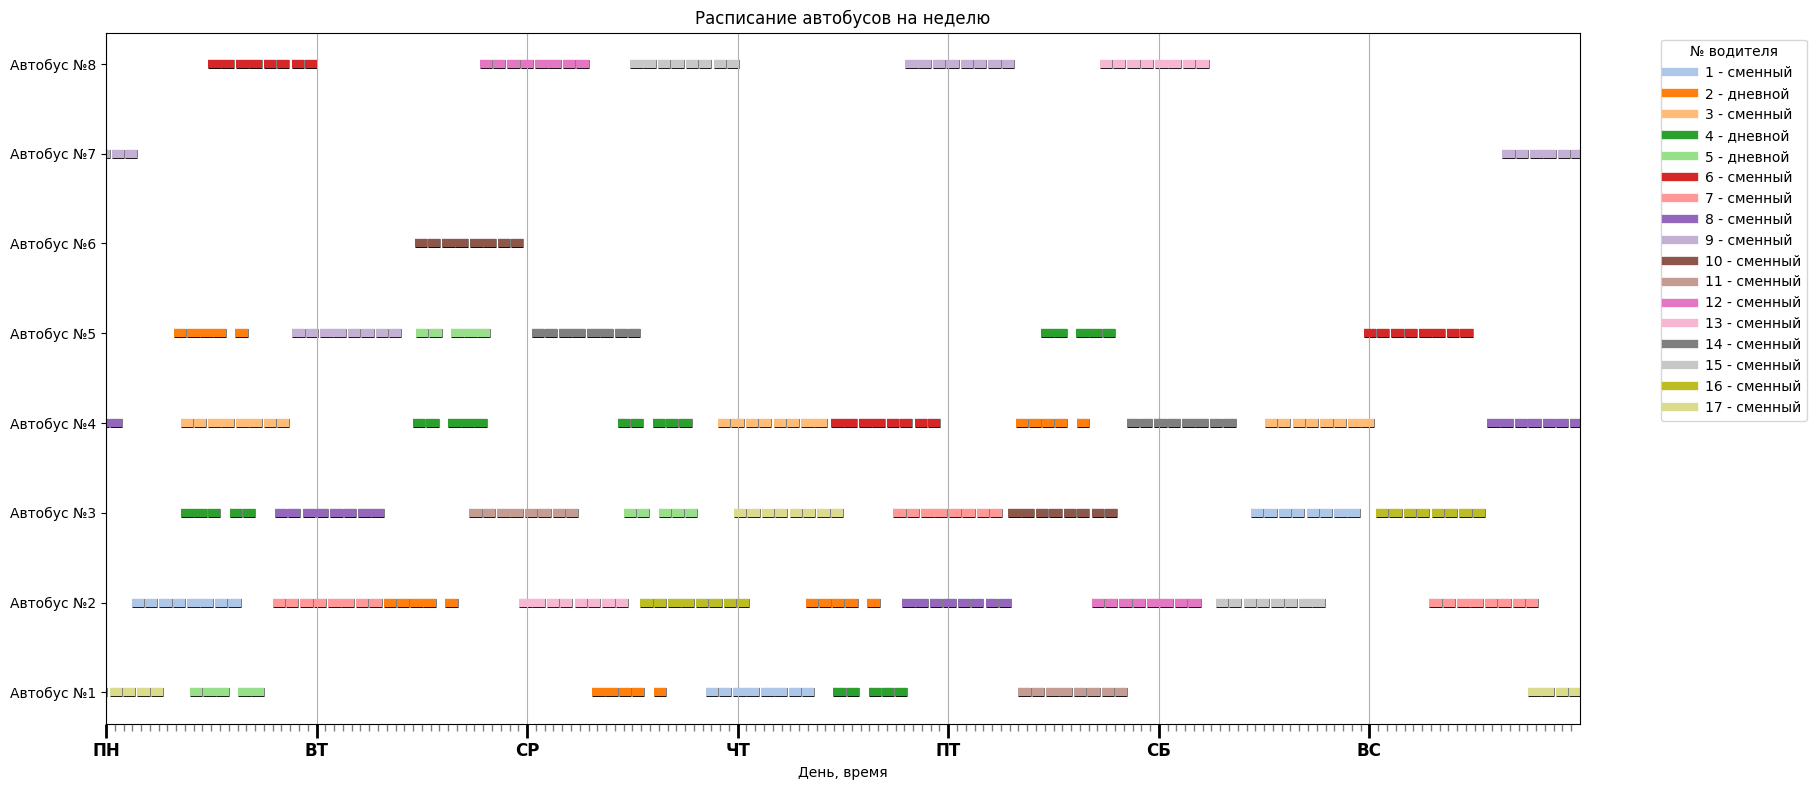

In [10]:
display_multiple_interval_trees_and_get_drivers(best_schedules[-1])

In [11]:
best_schedules[-1].marked_buses[4].schedule

IntervalTree([Interval(93, 110, '2.1'), Interval(111, 128, '2.1'), Interval(129, 146, '2.1'), Interval(147, 164, '2.1'), Interval(177, 194, '2.1'), Interval(255, 272, '9.0'), Interval(273, 290, '9.0'), Interval(293, 310, '9.0'), Interval(311, 328, '9.0'), Interval(331, 348, '9.0'), Interval(349, 366, '9.0'), Interval(369, 386, '9.0'), Interval(387, 404, '9.0'), Interval(424, 441, '5.1'), Interval(442, 459, '5.1'), Interval(472, 489, '5.1'), Interval(490, 507, '5.1'), Interval(508, 525, '5.1'), Interval(582, 599, '14.0'), Interval(600, 617, '14.0'), Interval(620, 637, '14.0'), Interval(638, 655, '14.0'), Interval(658, 675, '14.0'), Interval(676, 693, '14.0'), Interval(696, 713, '14.0'), Interval(714, 731, '14.0'), Interval(1279, 1296, '4.1'), Interval(1297, 1314, '4.1'), Interval(1327, 1344, '4.1'), Interval(1345, 1362, '4.1'), Interval(1363, 1380, '4.1'), Interval(1720, 1737, '6.0'), Interval(1738, 1755, '6.0'), Interval(1758, 1775, '6.0'), Interval(1776, 1793, '6.0'), Interval(1796, 1

In [12]:
def first_null(i):
    if i<10:
        return "0"+str(i)
    else: return i

def display_drivers(drivers:list[Driver]):
    days = ["Понедельник", "Вторник", "Среда", "Четверг", "Пятница", "Суббота", "Воскресенье"]
    rows = []
    for idx, dr in enumerate(drivers):
        row = {"№": f"Водитель {idx + 1}"}
        if dr.dr_type:
            row["Тип"] = "Дневной"
        else:
            row["Тип"] = "Сменный"
        for start, end in dr.dr_schedule:
            day = days[start//288] 
            if day not in row:
                row[day] = []
            row[day].append((start, end))
        for day in row:
            if isinstance(row[day], list):
                row[day] = ", ".join([f"{first_null((s%288)//12)}:{first_null((s%12)*5)}-{first_null((e%288)//12)}:{first_null((e%12)*5)}" for s, e in row[day]])
        rows.append(row)
    df = pd.DataFrame(rows)
    df = df[['№', 'Тип', "Понедельник", "Вторник", "Среда", "Четверг", "Пятница", "Суббота", "Воскресенье"]]
    df = df.fillna("")
    return df

In [13]:
display_drivers(best_schedules[-1].driver_list)

,№,Тип,Понедельник,Вторник,Среда,Четверг,Пятница,Суббота,Воскресенье
0,Водитель 1,Сменный,02:55-15:20,,20:20-08:45,,,10:30-22:55,
1,Водитель 2,Дневной,07:45-16:10,07:40-16:05,07:25-15:50,07:45-16:10,07:40-16:05,,
2,Водитель 3,Сменный,08:30-20:55,,21:45-10:10,,,12:05-00:30,
3,Водитель 4,Дневной,08:35-17:00,11:00-19:25,10:20-18:45,10:55-19:20,10:35-19:00,,
4,Водитель 5,Дневной,09:35-18:00,11:20-19:45,11:00-19:25,,,,
5,Водитель 6,Сменный,11:40-00:05,,,10:40-23:05,,23:20-11:45,
6,Водитель 7,Сменный,19:00-07:25,,,17:45-06:10,,,06:50-19:15
7,Водитель 8,Сменный,19:15-07:40,,,18:45-07:10,,,13:25-01:50
8,Водитель 9,Сменный,21:15-09:40,,,19:05-07:30,,,15:10-03:35
9,Водитель 10,Сменный,,11:10-23:35,,,06:50-19:15,,
